# Network Interpretability | proximity-quadrotor-learning

https://github.com/idsia-robotics/proximity-quadrotor-learning

## Settings

In [6]:
################################
### KNOWN IMPORTS
######

import math
import os
import time
import errno
import random
import sys
import gc
from datetime import datetime

# %tensorflow_version 1.x
import tensorflow as tf

# when importing keras, please notice:
#   https://stackoverflow.com/a/57298275/10866825
#   https://www.pyimagesearch.com/2019/10/21/keras-vs-tf-keras-whats-the-difference-in-tensorflow-2-0/

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# !pip install resnet
# import resnet as kr

import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.metrics

import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

# -- for GradCAM
!pip install tf-keras-vis
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from matplotlib import cm


################################
### PATHS
######

# this file goes into the 'PROJECT_ROOT/src/' folder to work properly with the following paths

try:
  import google.colab
  IN_COLAB = True
  from google.colab import drive
  from google.colab.patches import cv2_imshow
  drive.mount('/content/drive')
  %cd '/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/notebooks/'
except:
  IN_COLAB = False
  from cv2 import imshow as cv2_imshow


this_folder = os.path.realpath('.') # see https://stackoverflow.com/a/32711758/10866825 for details
lib_folder = os.path.join(this_folder, './functions/')
original_models_folder = os.path.join(this_folder, './../dev-models/_originals/') # Dario's original trained models (https://drive.switch.ch/index.php/s/Idsyf8WIwQpvRMF)
original_datasets_folder = os.path.join(this_folder, './../dev-datasets/_originals/') # Dario's original dataset (https://drive.switch.ch/index.php/s/8clDQNH645ZjWDD)
backgrounds_folder = os.path.join(this_folder, './../dev-datasets/_backgrounds/')
new_models_folder = os.path.join(this_folder, './../dev-models/')
new_datasets_folder = os.path.join(this_folder, './../dev-datasets/')
visualization_folder = os.path.join(this_folder, './../dev-visualization/')

dario_model_path = original_models_folder + 'v1_model_train_size_50000_rep_1.h5'
dario_train_path = original_datasets_folder + 'dario/v1_train.pickle'
dario_test_path = original_datasets_folder + 'dario/v1_test.pickle'



################################
### CUSTOM IMPORTS
######

sys.path.append(lib_folder)
import general_utils
import keras_utils

import importlib
importlib.reload(general_utils)
importlib.reload(keras_utils)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/notebooks


<module 'keras_utils' from '/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/notebooks/./functions/keras_utils.py'>

## Dataset and Model

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/notebooks/./../dev-datasets/_originals/dario/v1_train.pickle
dataset original shape: (63726, 3)
dataset keep shape: 	(63726, 3)
img_data shape: 	(63726,)
x_data shape: 		(63726, 60, 108, 3)
y_data shape: 		(63726, 4)
odom_dataset shape: 	(63726, 2)


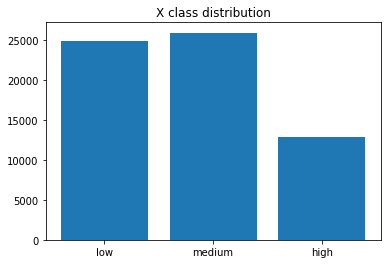

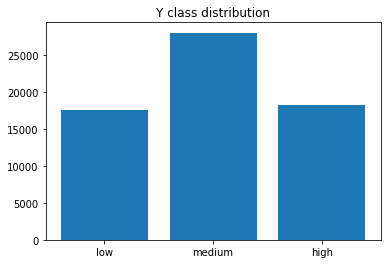

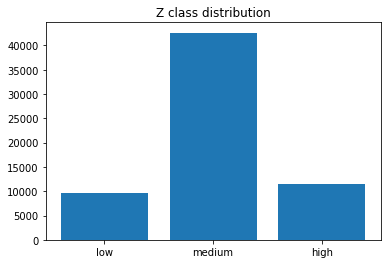

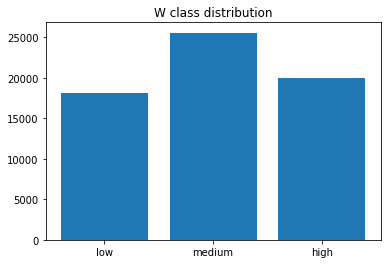

y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (63726,)
y_data_for_network single classification variable (4:8) 	 (63726, 3)


In [ ]:
train_img, train_x, train_y, train_actual, train_odom = general_utils.get_dataset_from_pickle(dario_train_path, dataset_keep_ratio = 1, plot_actual_distribution=True)

In [ ]:
demo_models_folder = new_models_folder + '06-02 demo/'

vis_model_all, vis_models = keras_utils.network_import_variants(demo_models_folder)
vis_model_x, vis_model_y, vis_model_z, vis_model_w = vis_models

Models imported from /content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-models/06-02 demo/


## Network Interpretability

Most of the libraries, such as `tf-explain` or `keras-vis`, give [this issue](https://github.com/sicara/tf-explain/issues/116) if run with nested models.  
That is why we choose to reconstruct the model without nesting.

We tried [keras-vis](https://github.com/raghakot/keras-vis) with [this tutorial](https://fairyonice.github.io/Grad-CAM-with-keras-vis.html), but `keras-vis` directly uses `keras` instead of `tensorflow.keras`, then it is not compatible with our model and we get [this error](https://stackoverflow.com/questions/58878421/unexpected-keyword-argument-ragged-in-keras) if trying to use it. See also [this](https://stackoverflow.com/a/57298275/10866825) and [this](https://www.pyimagesearch.com/2019/10/21/keras-vs-tf-keras-whats-the-difference-in-tensorflow-2-0/ ) for information about the difference between `keras` and `tensorflow.keras`.   
We instead rely on [tf-keras-vis](https://github.com/keisen/tf-keras-vis) as suggested [here](https://github.com/raghakot/keras-vis/issues/160#issuecomment-567930344), following [this GradCAM tutorial](https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb).

### Data selection, prediction and tranformation


Take care on images `1750, 20600, 27600, 29750`.  
Also images `1360, 3152, 4588, 6468, 7021, 7983, 9778, 10410, 11156, 18337, 20657, 24553, 27670, 29014, 30199`.

In [ ]:
video_length = 500
vis_index_start = 1 # if None or 0, random selection will be used
vis_img, vis_input, vis_actuals, vis_predictions_best, vis_index_start = keras_utils.gradcam_data_select_predict_transform(vis_models, train_img, train_x, train_actual, video_length, vis_index_start)

selected indexes are from 1 to 501 

x_class actual 		 ['medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low

### GradCAM

#### Same frame on Predicted and Ground Truth classes

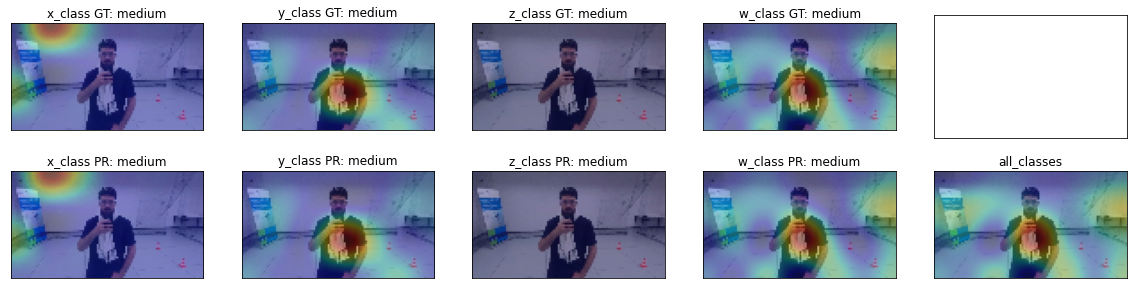

In [ ]:
idx = 300
keras_utils.gradcam_plot_pred_vs_gt(
    vis_img, vis_input, vis_actuals, vis_predictions_best, 
    vis_model_all, vis_models, idx
)

#### Frames tabulated per variable (row) and loss (column)

Progress frame 0/1


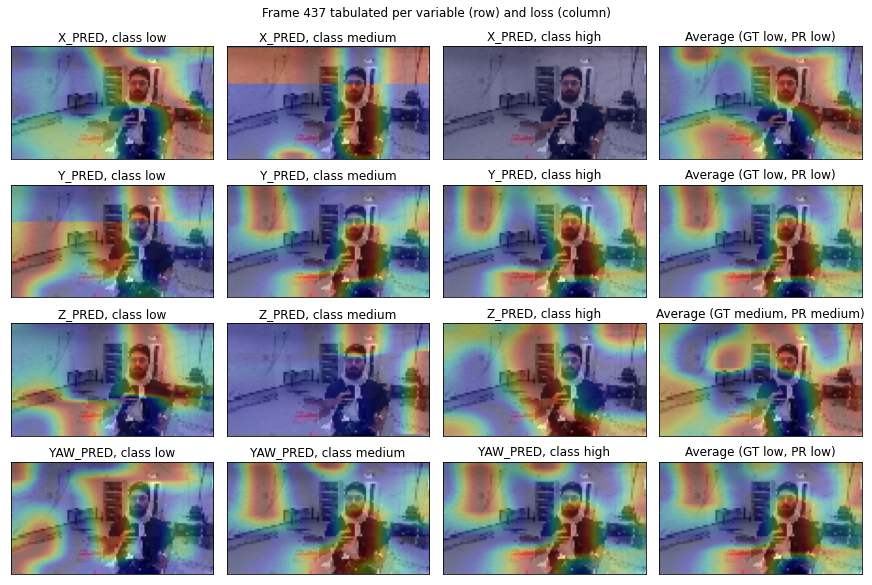

In [ ]:
### Random chosen frames

max_frames = 1
nplotted = np.min([max_frames, video_length])

var_types = [0, 1, 2, 3] # X:0, Y:1, Z:2, W:3
loss_types = [0, 1, 2, 3] # low:0, medium:1, high:2, total:3
frames = np.random.choice(range(vis_input.shape[0]), nplotted, p = keras_utils.get_wave_distribution(vis_input.shape[0]))
per_var__loss_folder = visualization_folder + 'gradcam/per-variable-loss-comparison/'

keras_utils.gradcam_comparison_varloss(
    vis_img, vis_input, vis_actuals, vis_predictions_best, vis_index_start,
    var_types, loss_types, vis_models, frames, 
    per_var__loss_folder, notes = 'tabulated', title = True, save = False
)

Progress frame 0/5


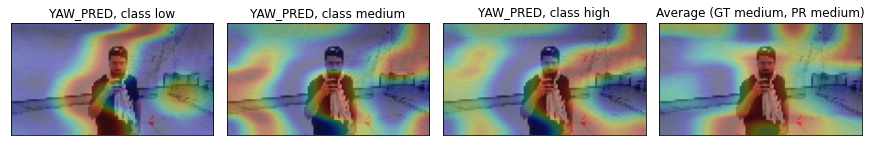

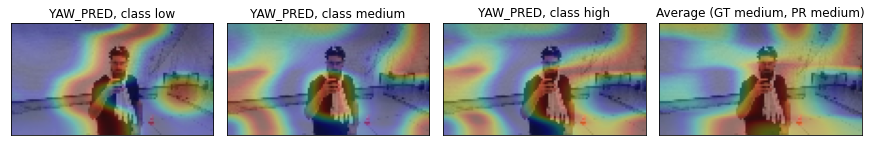

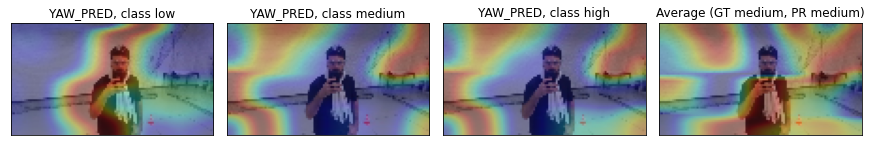

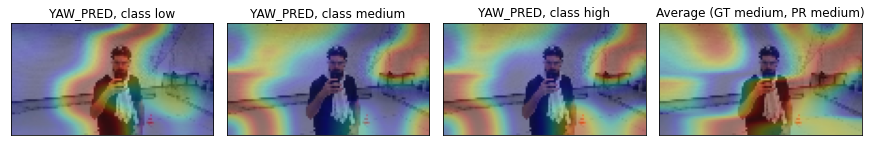

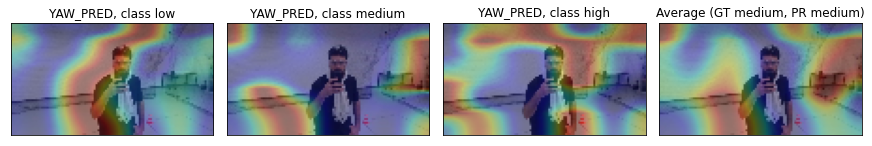

In [ ]:
### Consecutive frames for video making

max_frames = 5
nplotted = np.min([max_frames, video_length]) 
random_start = np.random.randint(0, vis_input.shape[0] - nplotted - 1)

var_types = [3] # X:0, Y:1, Z:2, W:3
loss_types = [0, 1, 2, 3] # low:0, medium:1, high:2, total:3
frames = np.arange(random_start, random_start + nplotted)
per_var__loss_folder = visualization_folder + 'gradcam/per-variable-loss-comparison/'

keras_utils.gradcam_comparison_varloss(
    vis_img, vis_input, vis_actuals, vis_predictions_best, vis_index_start,
    var_types, loss_types, vis_models, frames, 
    per_var__loss_folder, notes = 'video class ' + str(var_types), title = False, save = False
)

#### No more used

In [ ]:
#### Consecutive frames of ALL variables with TOTAL loss

# gradcam = Gradcam(vis_model_all, model_modifier_classification)
# cam = gradcam(loss_total, vis_input)

# ncols = 5
# nplotted = np.min([10, video_length])
# nrows = np.ceil(nplotted / ncols).astype(int)
# f, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3), subplot_kw={'xticks': [], 'yticks': []})

# for i in range(nplotted):
#   if(nplotted == 1 and ncols == 1):
#     cell = ax
#   elif(nrows == 1):
#     cell = ax[i]
#   else:
#     cell = ax[i//ncols, i%ncols]
#   heatmap = np.uint8(cm.jet(normalize(cam[i]))[..., :3] * 255)
#   cell.imshow(vis_img[i])
#   cell.imshow(heatmap, cmap='jet', alpha=0.3)

In [ ]:
#### Image saving for making a video on ALL variables and TOTAL loss

# foldername = access_datetime_folder(visualization_folder + 'gradcam/frames/', 'video frames')
# print(foldername)

# gradcam = Gradcam(vis_model_all, model_modifier_classification)
# cam = gradcam(loss_total, vis_input)

# f, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), subplot_kw={'xticks': [], 'yticks': []})
# for i in range(np.min([500, video_length])):
#   if i % 50 == 0:
#     print('Progress: frame', i)
#   heatmap = np.uint8(cm.jet(normalize(cam[i]))[..., :3] * 255)
#   ax.imshow(vis_img[i])
#   ax.imshow(heatmap, cmap='jet', alpha=0.3)
#   ax.figure.savefig(foldername + "{:04d}".format(i) + '.jpg')

# print('Progress: COMPLETED')

In [ ]:
#### Consecutive frames of CUSTOM variables and classes

# max_frames = 5
 
# ncols = 5
# nplotted = np.min([max_frames, video_length])
# nrows = np.ceil(nplotted / ncols).astype(int)

# offset = np.random.randint(0, vis_input.shape[0] - nplotted - 1) # random selection

# # per_var__loss_folder = create_datetime_folder(visualization_folder + 'gradcam/per-variable-loss-comparison/', 'consecutive for same variable')
# # print(per_var__loss_folder)


# for var_type in range(4): # X:0, Y:1, Z:2, W:3
#   for loss_type in range(4): # low:0, medium:1, high:2, total:3

#     gradcam = Gradcam(vis_models[var_type], model_modifier_last)
#     cam = gradcam(losses[loss_type], vis_input[offset:offset+nplotted+1])
    
#     f, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(int(ncols*3), int(nrows*2)), subplot_kw={'xticks': [], 'yticks': []}, constrained_layout=True)
#     suptitle = str.upper(general_utils.variables_names[var_type] + ' with loss ' + ('total' if loss_type == 3 else general_utils.var_labels[loss_type]))
#     f.suptitle(suptitle)

#     for i in range(nplotted):
#       if(nplotted == 1 and ncols == 1):
#         cell = ax
#       elif(nrows == 1):
#         cell = ax[i]
#       else:
#         cell = ax[i//ncols, i%ncols]

#       current_img_index = offset + i
#       heatmap = np.uint8(cm.jet(normalize(cam[i]))[..., :3] * 255)
#       celltitle = 'GT ' + vis_actuals[var_type][current_img_index] + ', PR ' + vis_predictions_best[var_type][current_img_index]
      
#       cell.set_title(celltitle)
#       cell.imshow(vis_img[current_img_index]) 
#       cell.imshow(heatmap, cmap='jet', alpha=0.3)
      
#       imagename = '{:02d} '.format((var_type+1) * (loss_type+1)) + suptitle + '.jpg'
    
#     # cell.figure.savefig(per_var__loss_folder + imagename)

### Vanilla Saliency & Smoothgrad

Saliency generate the saliency map that appears input regions that a change in the input value contribute the output value.

> Note: The softmax activation function which is applied to model's last layer may obstruct generating shape attention images, so that you need to replace the function to a linear function using model_modifier.

However, **Vanilla Saliency** map is too noisy, so that let's remove noise in saliency map using SmoothGrad! **SmoothGrad** is a algorithm that reduce noise including saliency map by adding noise to input image. You can control it through the parameter `smooth_samples`.



In [ ]:
# from tf_keras_vis.saliency import Saliency

# # Generate saliency map with smoothing that reduce noise by adding noise
# def perform_saliency(saliency_obj, title, loss, smooth=0):
  
#   saliency_map = saliency_obj(loss, vis_x, smooth_samples=smooth)
#   saliency_map = normalize(saliency_map)
#   f, ax = get_subplots()
#   f.suptitle(title, y=1.10) # y moves title up
  
#   for i in range(len(saliency_map)):
#     if(images_number == 1 and ncols == 1):
#       cell = ax
#     elif(nrows == 1):
#       cell = ax[i]
#     else:
#       cell = ax[i//ncols, i%ncols]

#     if var_index == None:
#       aa = str([var_labels[int(j)] for j in y_train[vis_idx[i],4:8]])
#       pp = str([var_labels[int(j)] for j in img_class_pred[i]])
#     else:
#       aa = var_labels[int(y_train[vis_idx[i],var_index])]
#       pp = var_labels[img_class_pred[i]]
#     cell.set_title('A: ' + aa + '\nP: ' + pp)
    
#     cell.imshow(vis_img[i])
#     cell.imshow(saliency_map[i], cmap='jet', alpha=0.3)


# # Generate GradCAM heatmaps
# def perform_gradcam(gradcam_obj, title, loss):
  
#   cam = gradcam_obj(loss, vis_x)
#   cam = normalize(cam)

#   f, ax = get_subplots()
#   f.suptitle(title, y=1.10) # y moves title up
#   for i in range(len(cam)):
#     if(images_number == 1 and ncols == 1):
#       cell = ax
#     elif(nrows == 1):
#       cell = ax[i]
#     else:
#       cell = ax[i//ncols, i%ncols]

#     if var_index == None:
#       aa = str([var_labels[int(j)] for j in y_train[vis_idx[i],4:8]])
#       pp = str([var_labels[int(j)] for j in img_class_pred[i]])
#     else:
#       aa = var_labels[int(y_train[vis_idx[i],var_index])]
#       pp = var_labels[img_class_pred[i]]
#     cell.set_title('A: ' + aa + '\nP: ' + pp)
    
#     heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
#     cell.imshow(vis_img[i])
#     cell.imshow(heatmap, cmap='jet', alpha=0.3)

In [ ]:
# saliency = Saliency(vis_model, model_modifier)

# smooth = 200
# if var_index == None:
#   considered_var = ''
# else:
#   considered_var = ' (' + variables_names[var_index] + ' var)'

# perform_saliency(saliency, 'LOW CLASS SALIENCY' + considered_var, loss_low)
# perform_saliency(saliency, 'LOW CLASS SMOOTHGRAD ' + str(smooth) + considered_var, loss_low, smooth)
# perform_gradcam(gradcam, 'LOW CLASS GRADCAM' + considered_var, loss_low)

# perform_saliency(saliency, 'MEDIUM CLASS SALIENCY' + considered_var, loss_medium)
# perform_saliency(saliency, 'MEDIUM CLASS SMOOTHGRAD ' + str(smooth) + considered_var, loss_medium, smooth)
# perform_gradcam(gradcam, 'MEDIUM CLASS GRADCAM' + considered_var, loss_medium)

# perform_saliency(saliency, 'HIGH CLASS SALIENCY' + considered_var, loss_high)
# perform_saliency(saliency, 'HIGH CLASS SMOOTHGRAD ' + str(smooth) + considered_var, loss_high, smooth)
# perform_gradcam(gradcam, 'HIGH CLASS GRADCAM' + considered_var, loss_high)

# perform_saliency(saliency, 'ALL CLASSES SALIENCY' + considered_var, loss_total)
# perform_saliency(saliency, 'ALL CLASSES SMOOTHGRAD ' + str(smooth) + considered_var, loss_total, smooth)
# perform_gradcam(gradcam, 'ALL CLASSES GRADCAM' + considered_var, loss_total)